In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = w.make_dataframe()

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Resample

### Downsampling

In [6]:
# Take out packets from router
df = df[df["DeviceType"]!="router"]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [7]:
df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

### Create downsampled trial dataframes

In [8]:
df_trials = []
num_trials = 10
for i in range(0,num_trials):
    # Down
    df_downsampled = w.downsample(X, y, df[df["Set"]=="test"])
    df_trials.append(df_downsampled)

In [9]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength", "Time",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

# Run trials

In [10]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = w.one_vs_all_classify(trial, features_list, y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports/Plots

### AUC

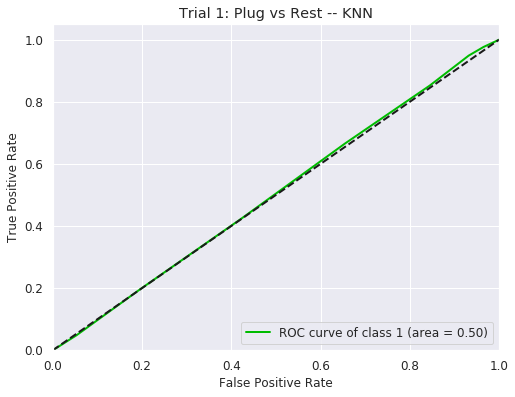

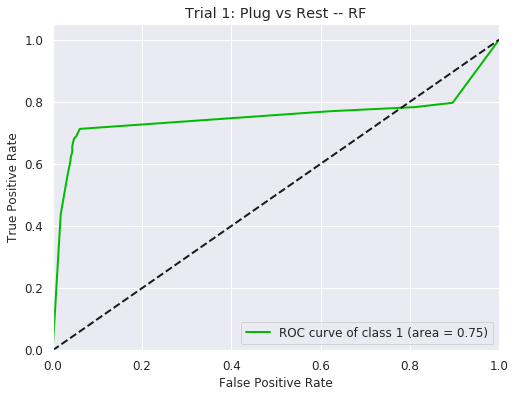

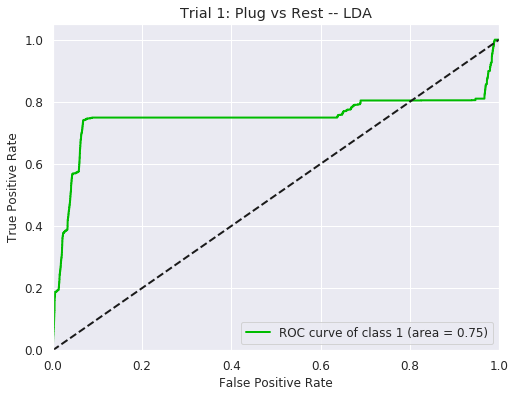

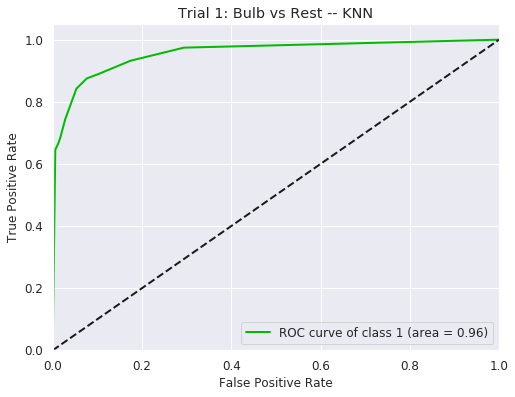

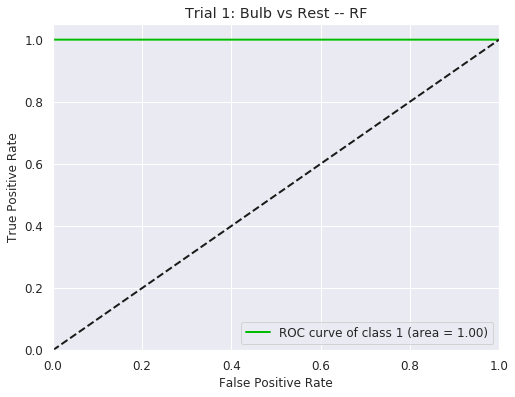

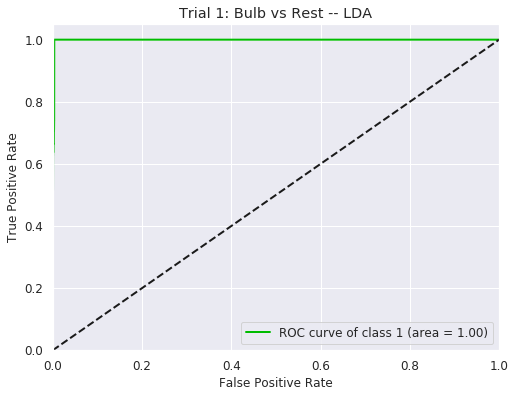

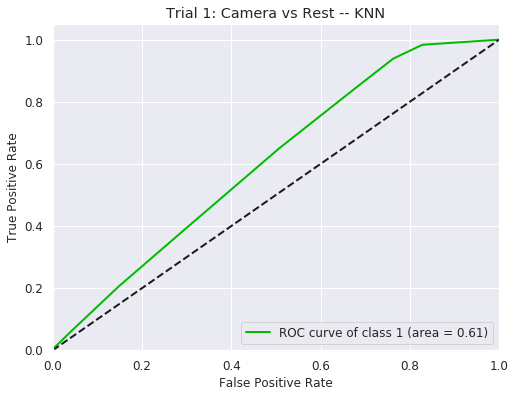

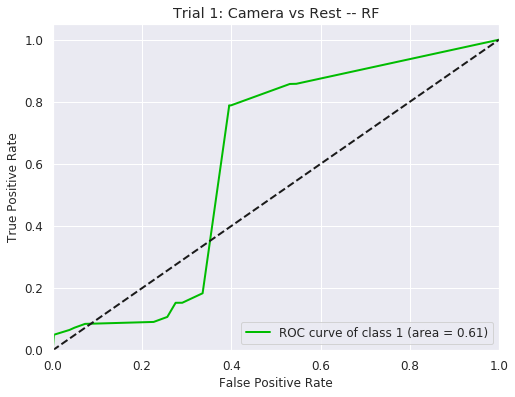

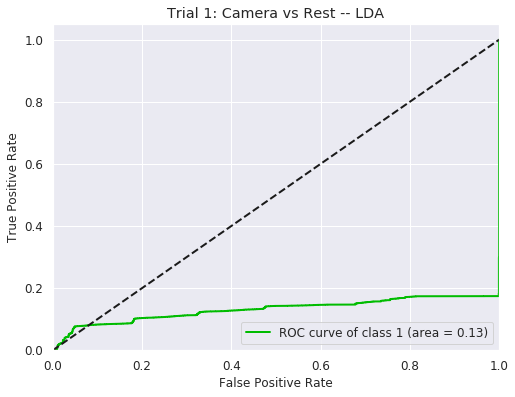

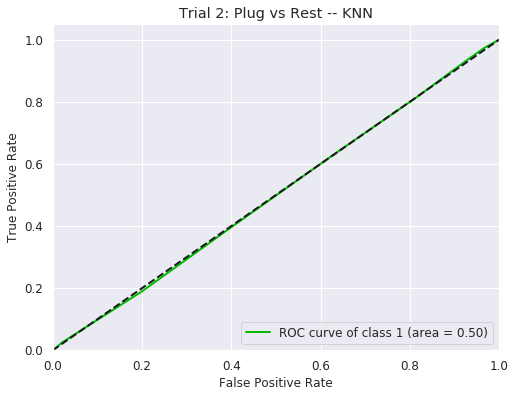

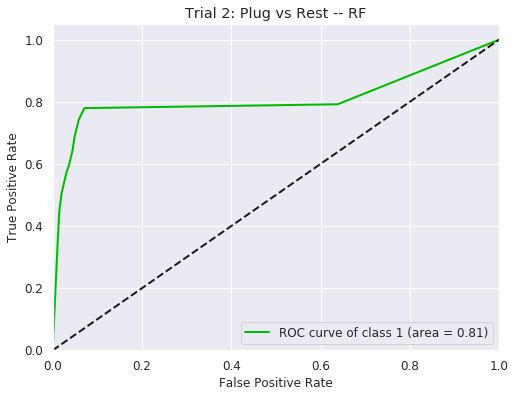

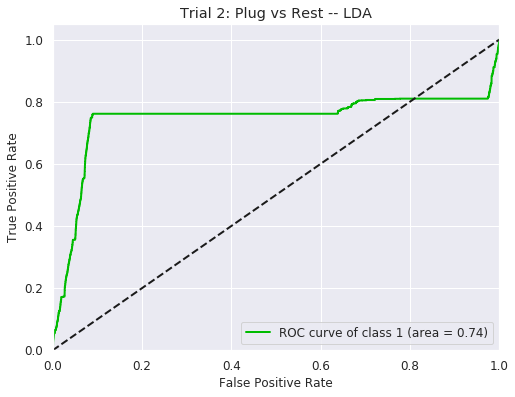

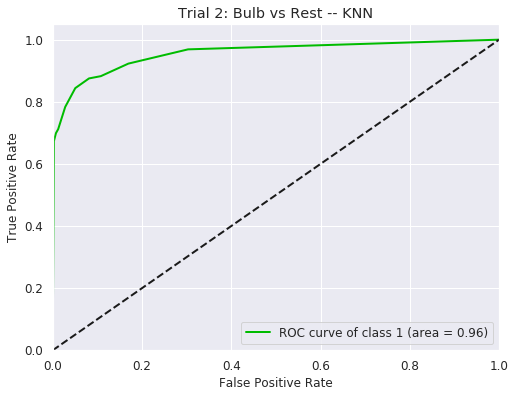

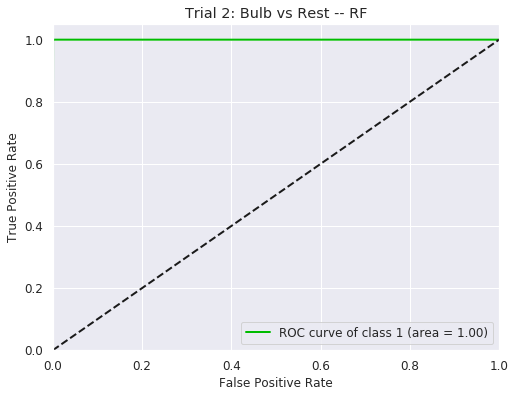

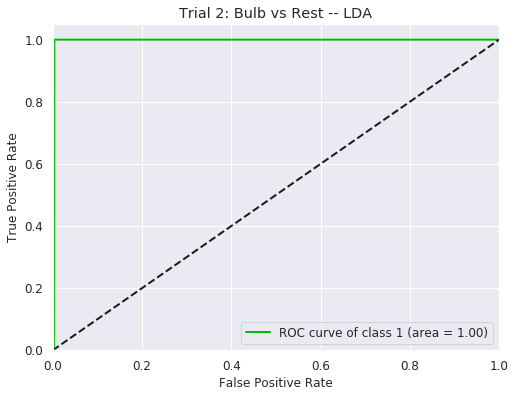

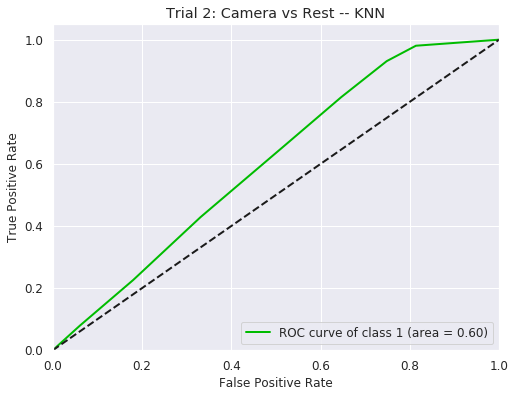

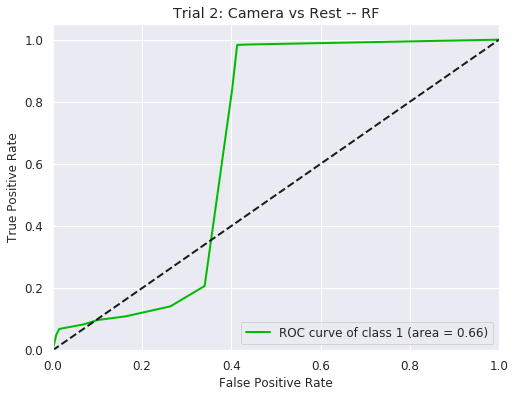

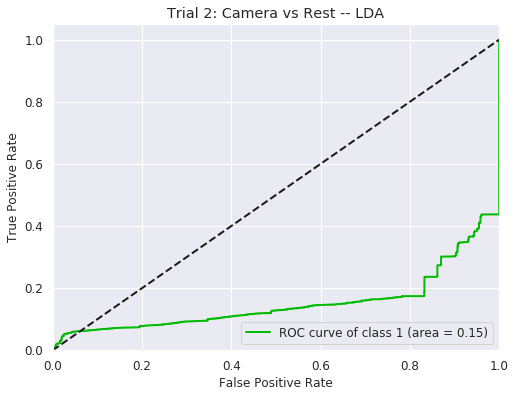

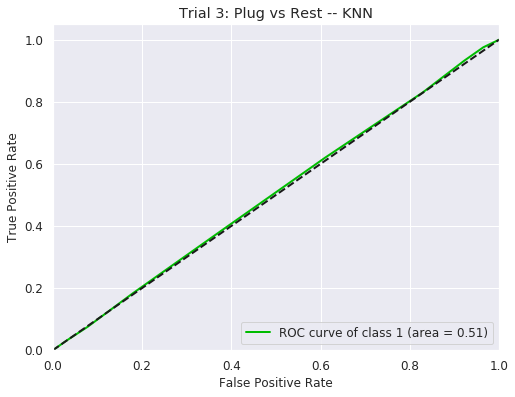

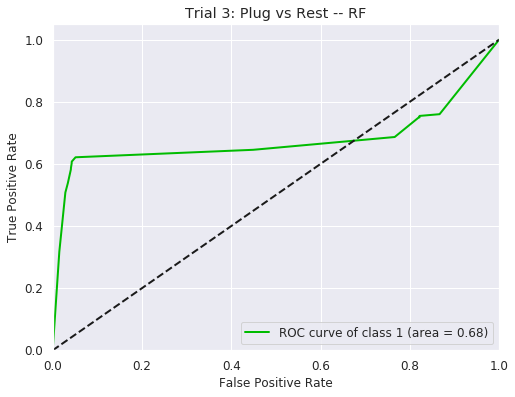

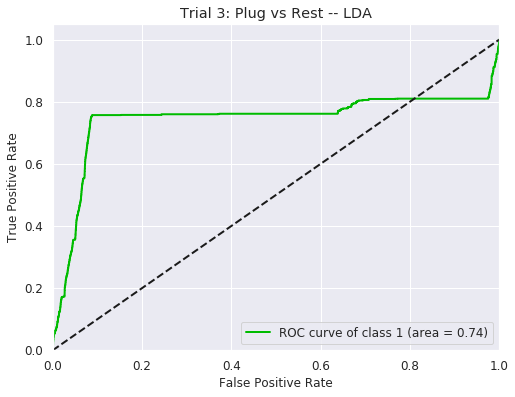

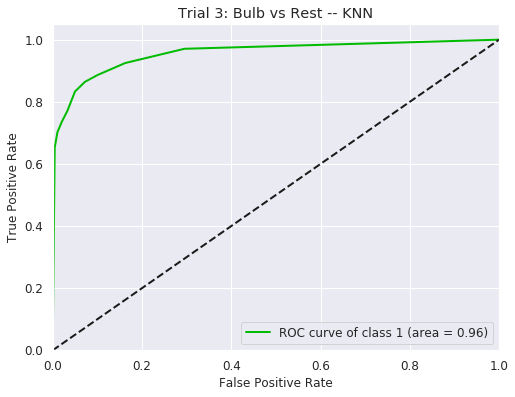

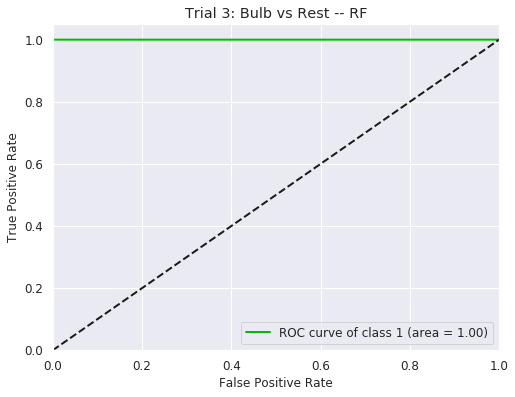

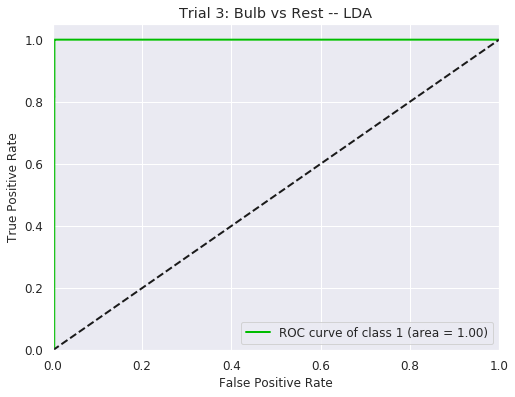

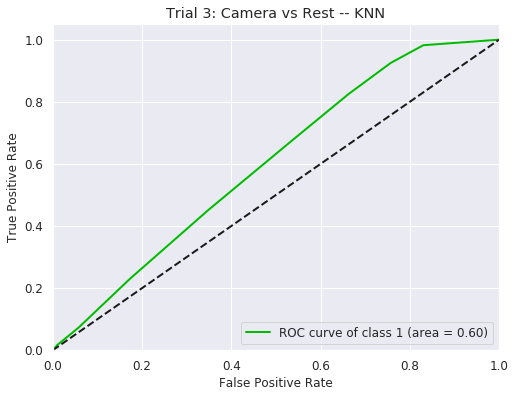

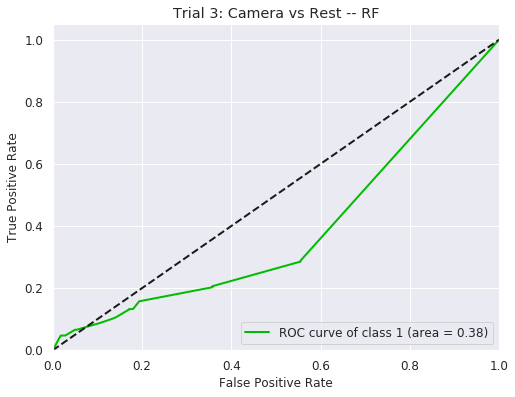

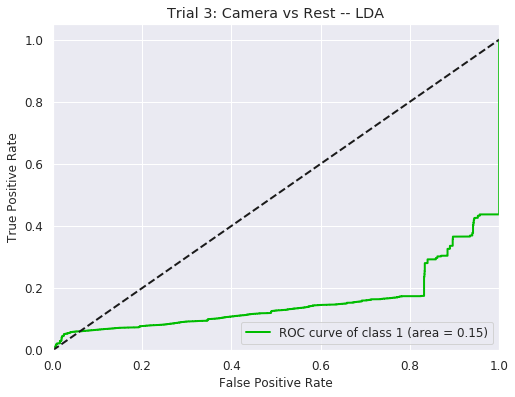

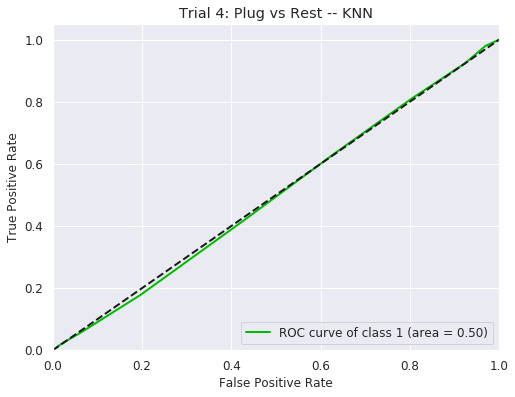

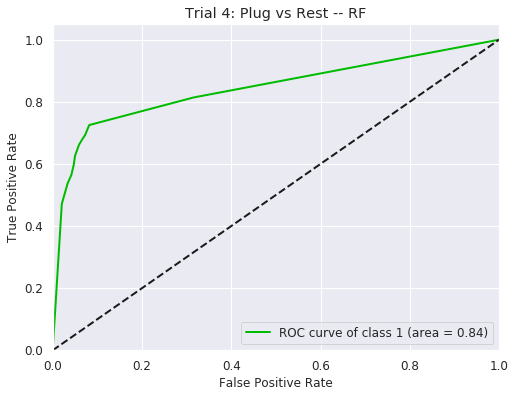

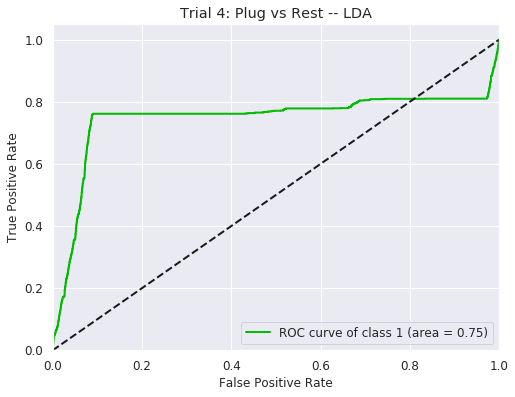

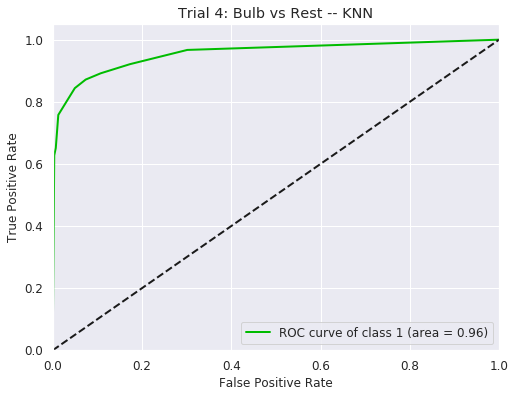

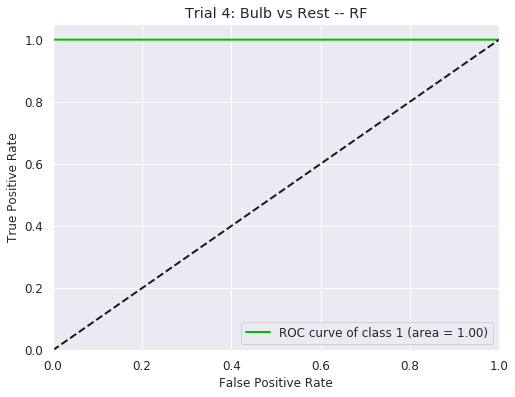

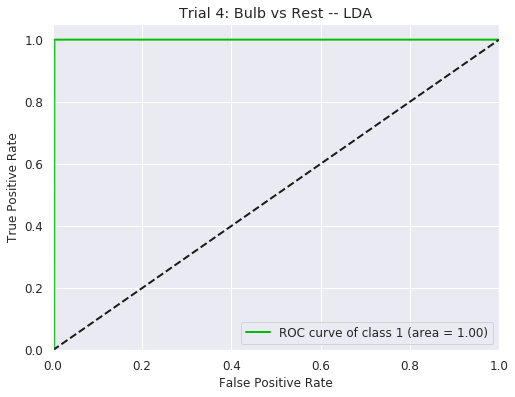

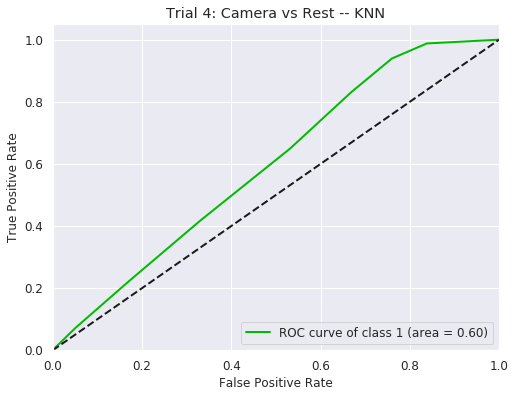

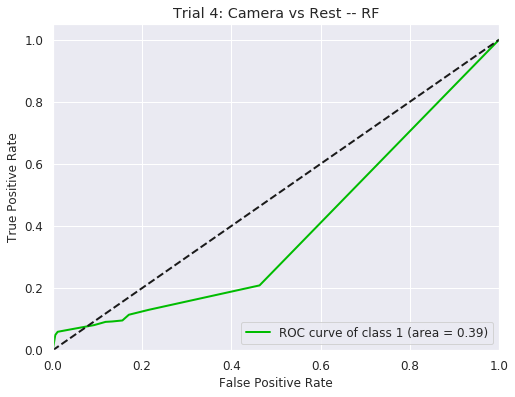

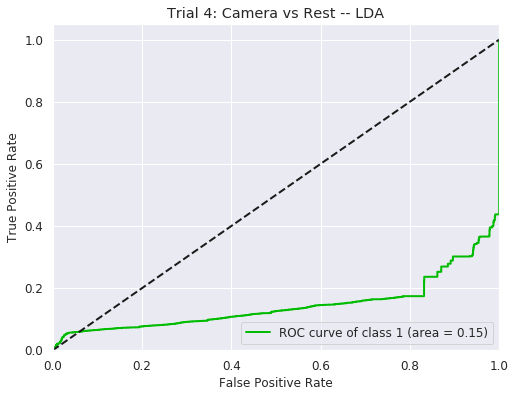

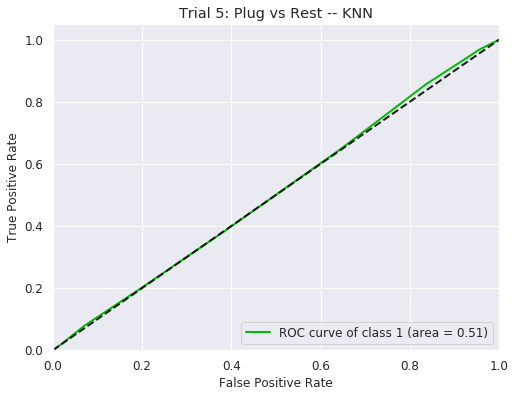

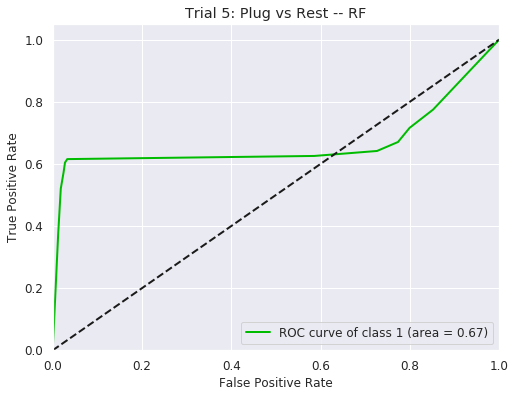

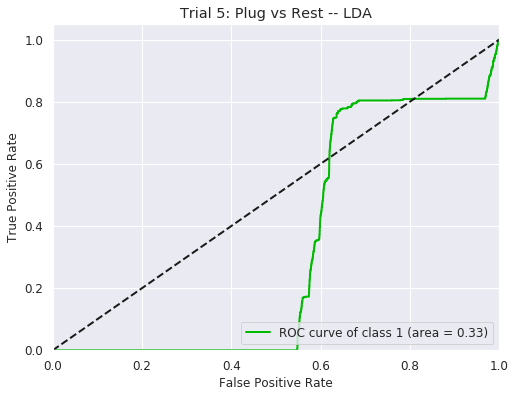

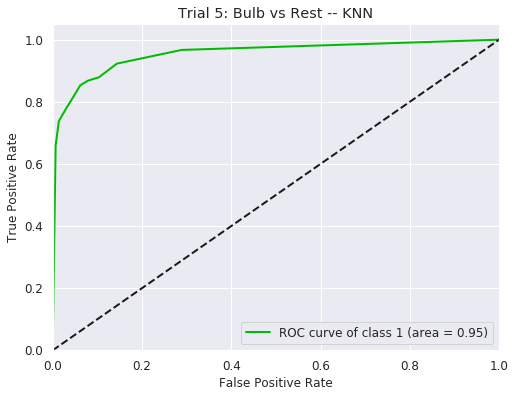

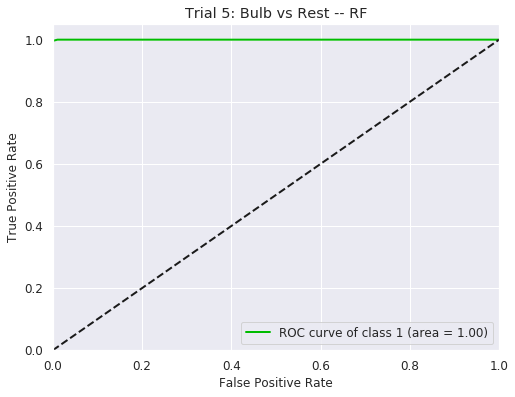

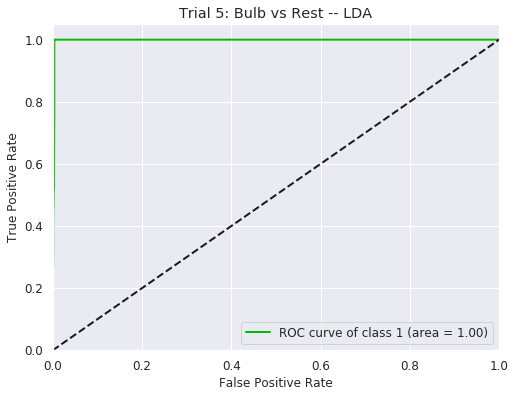

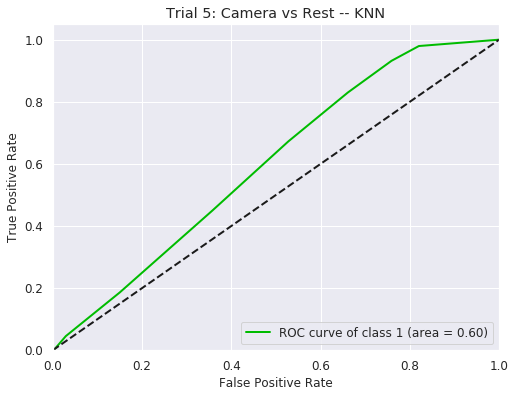

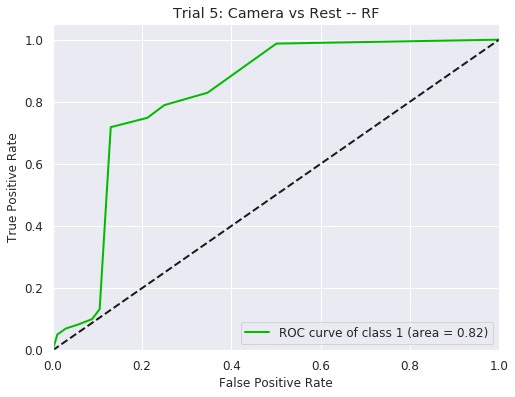

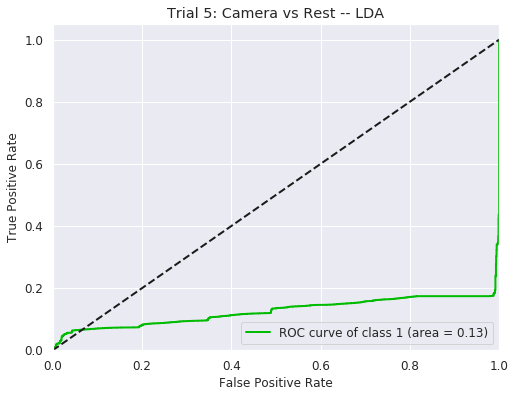

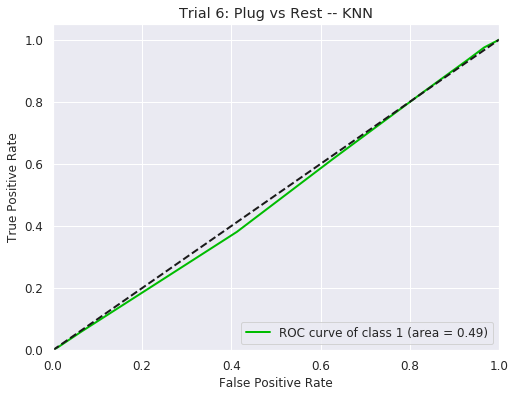

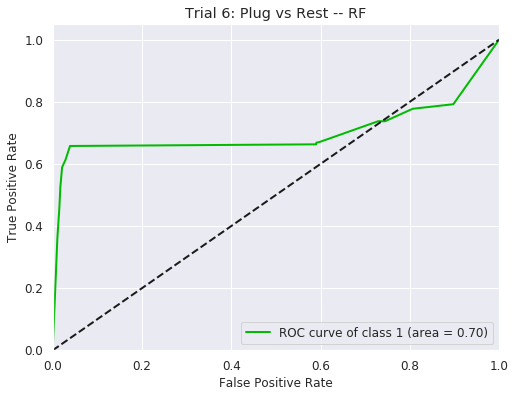

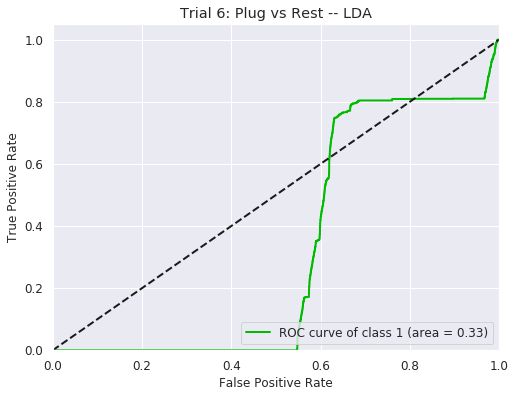

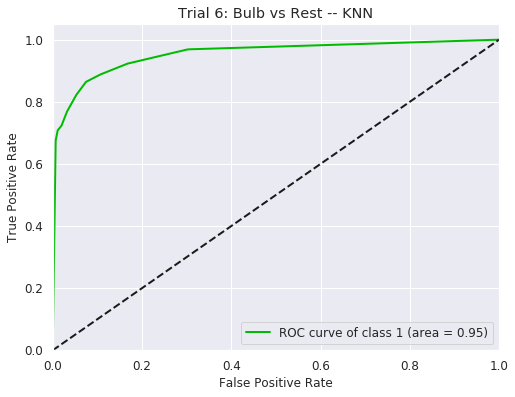

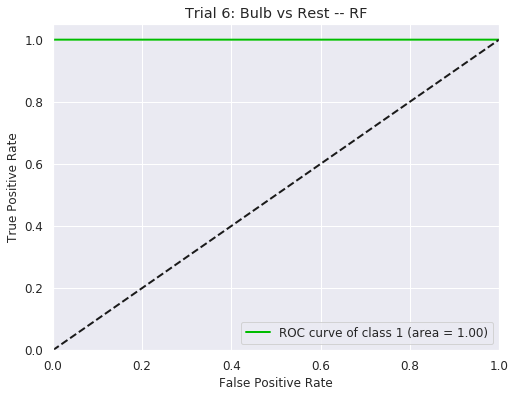

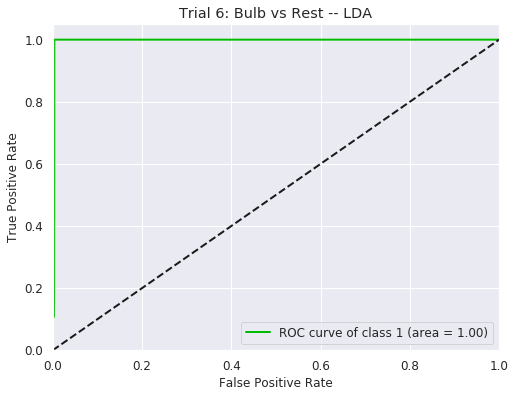

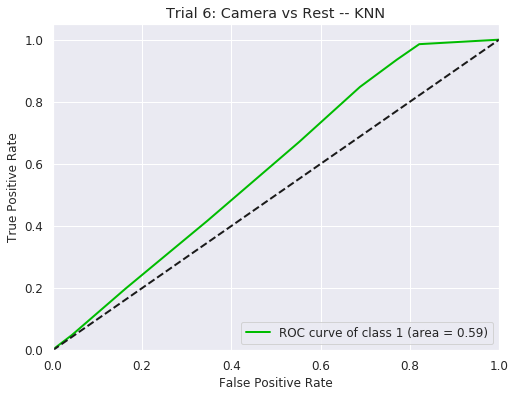

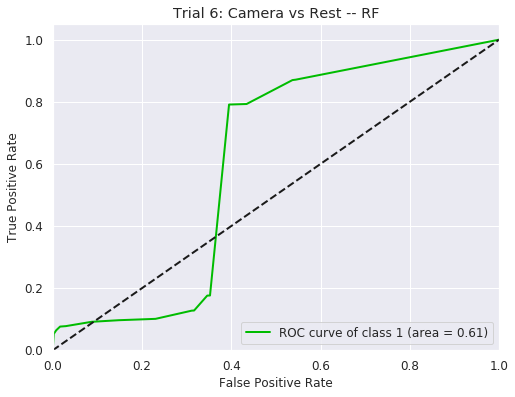

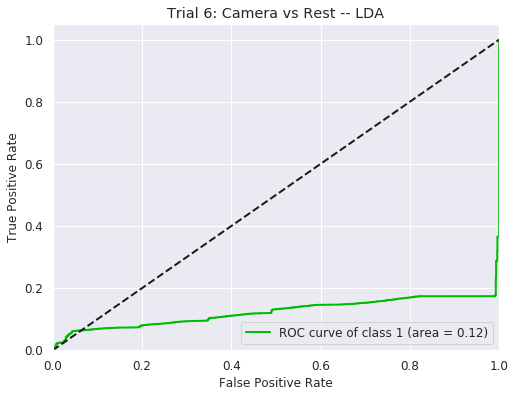

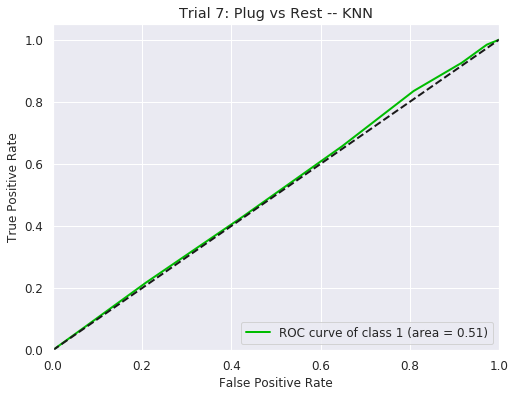

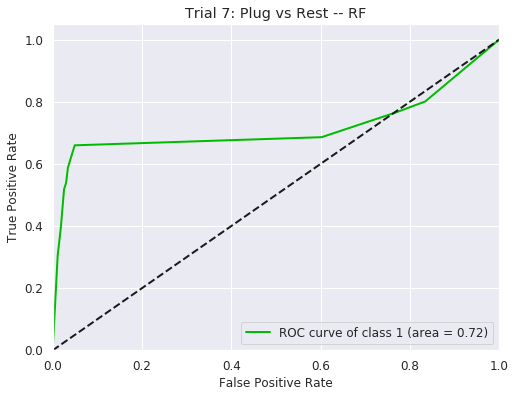

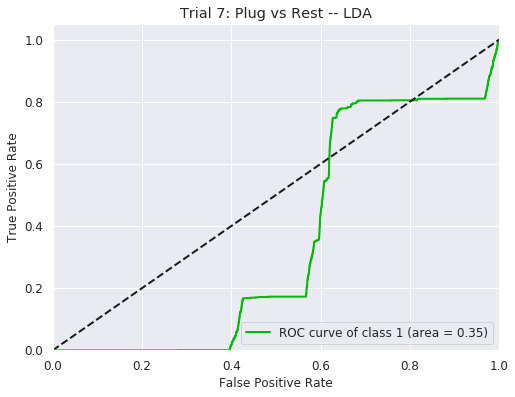

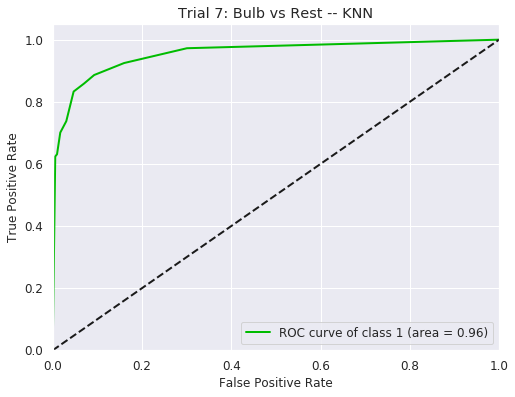

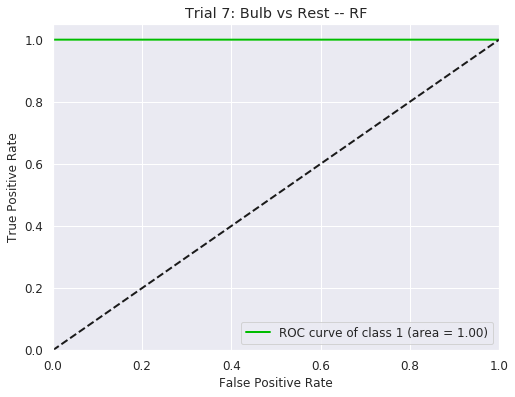

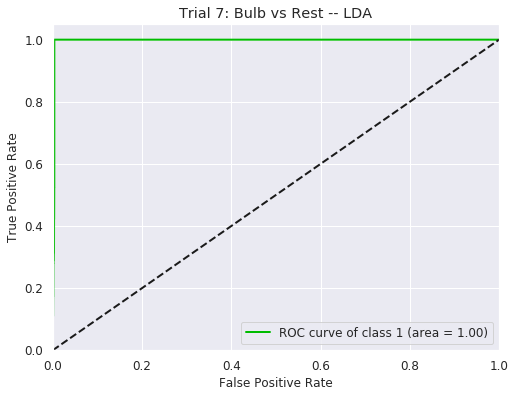

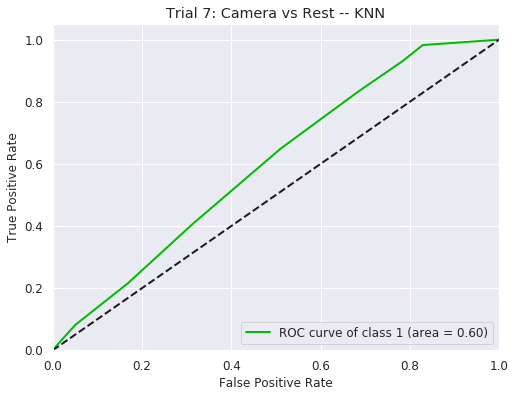

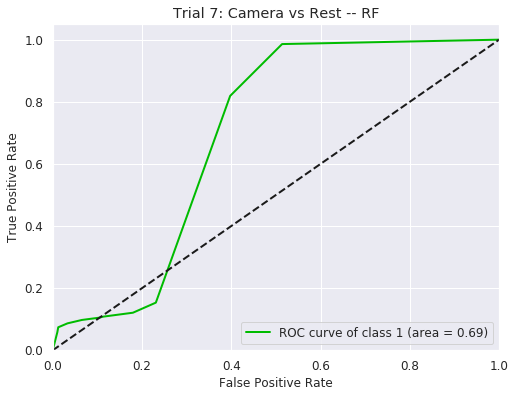

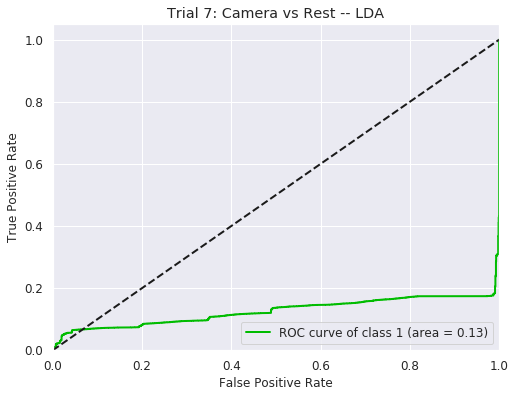

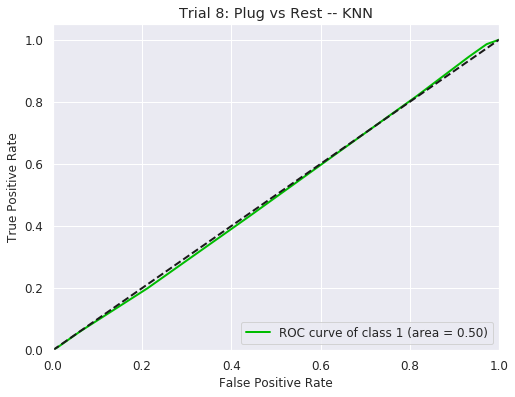

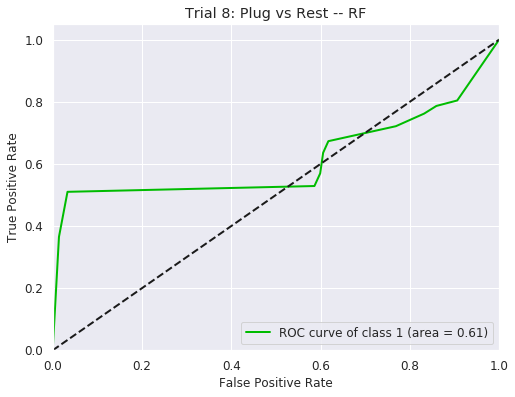

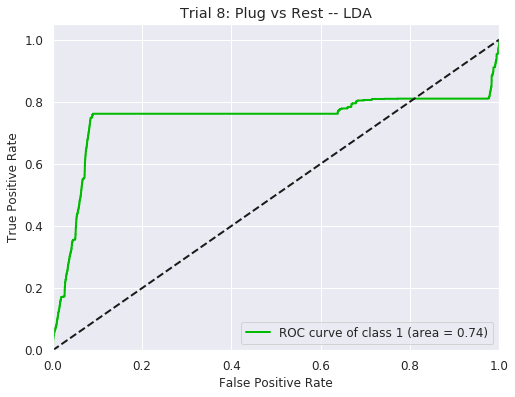

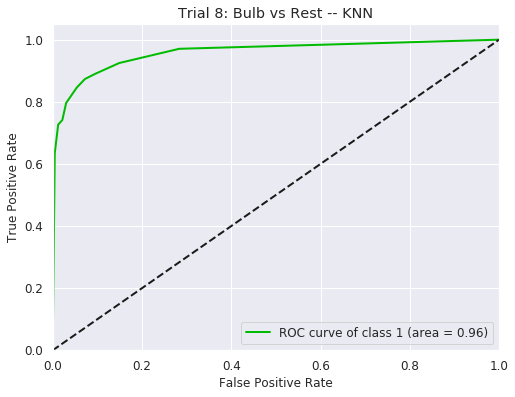

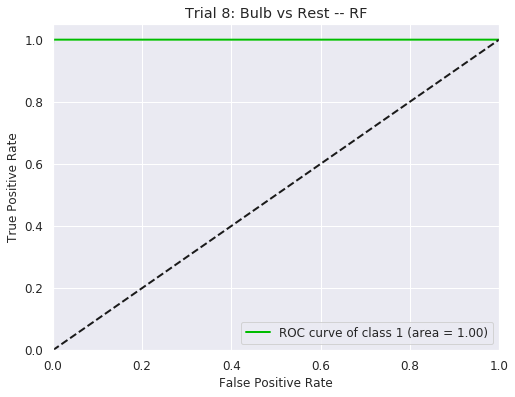

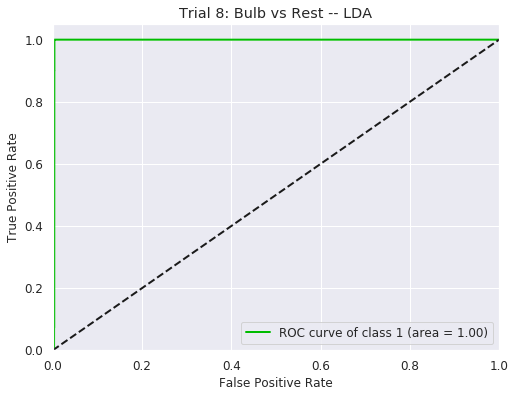

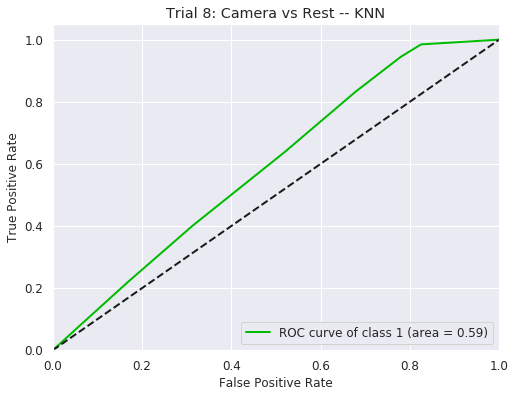

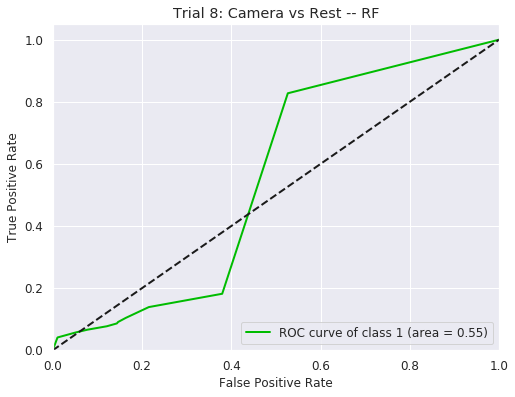

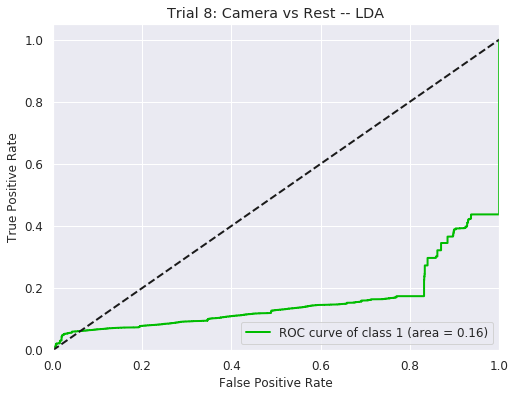

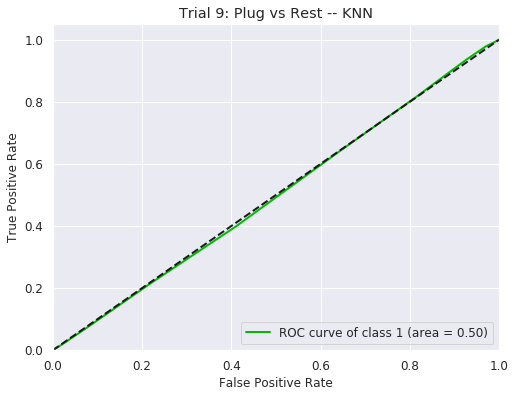

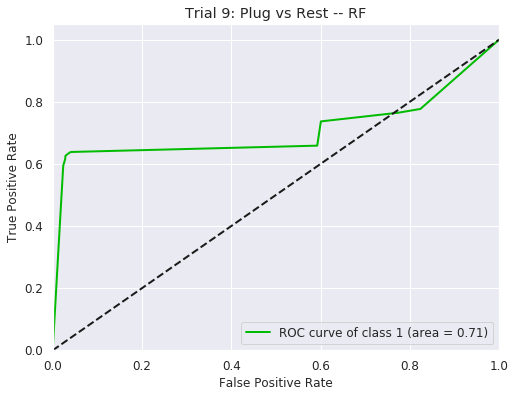

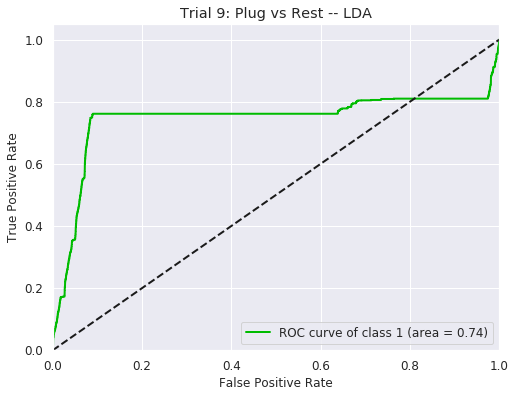

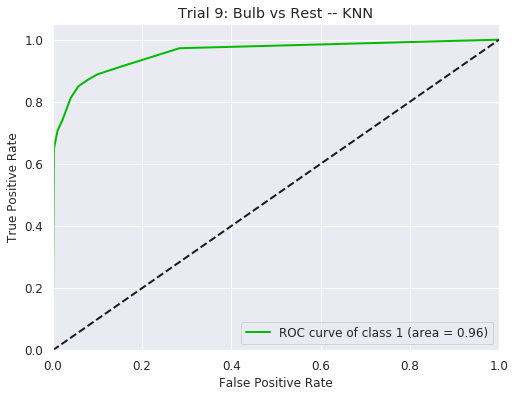

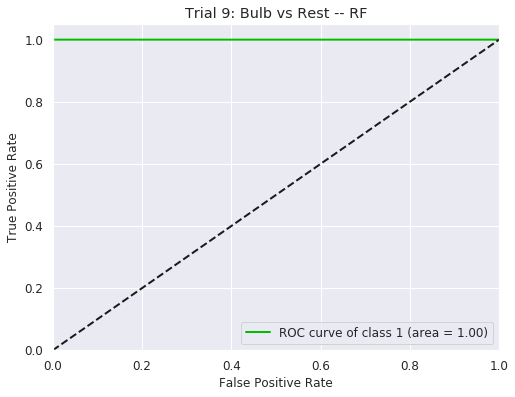

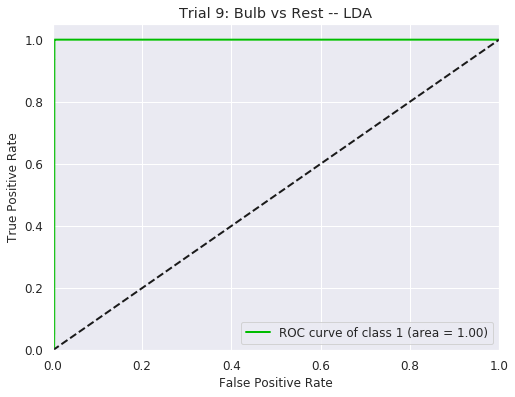

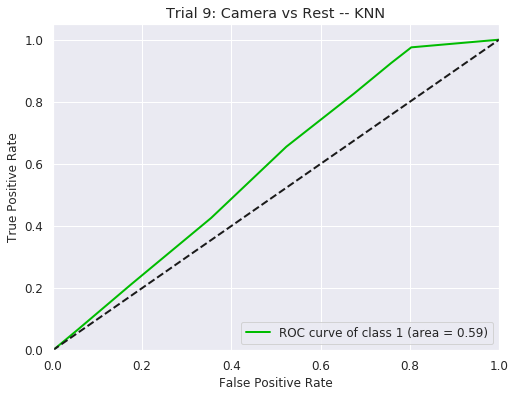

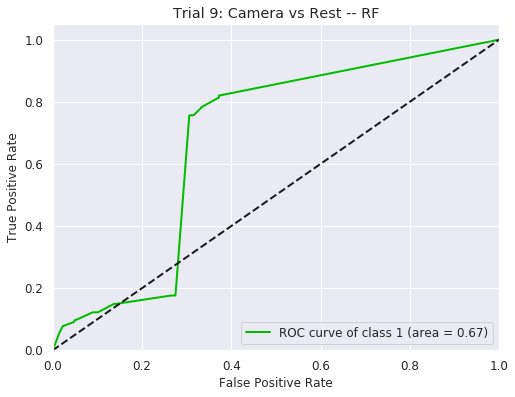

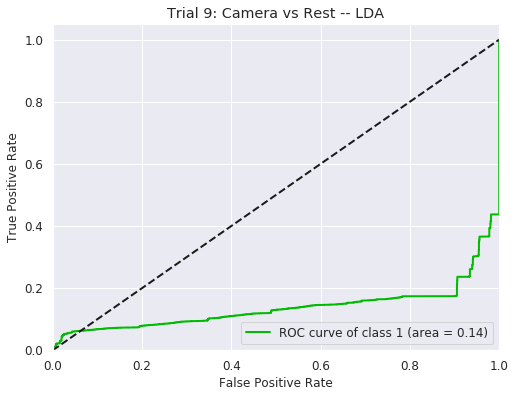

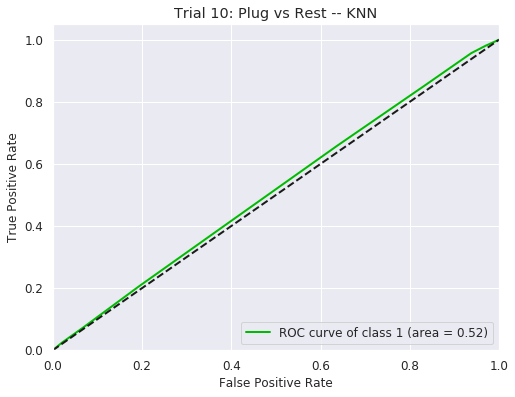

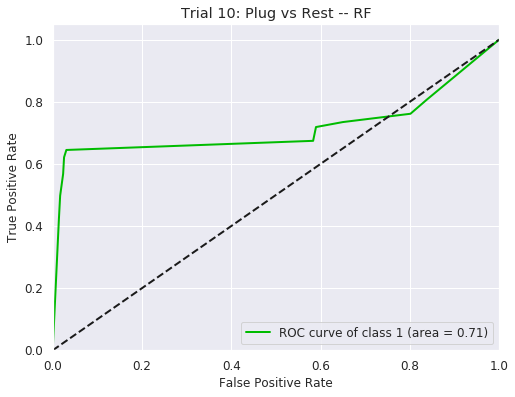

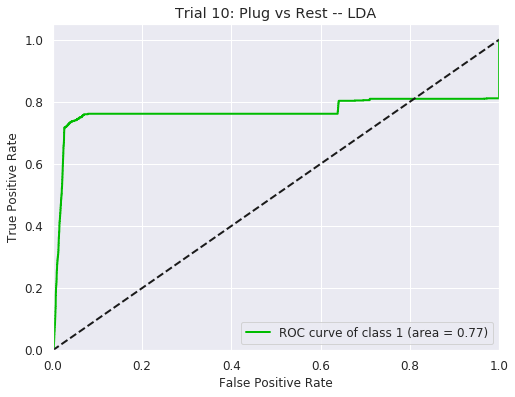

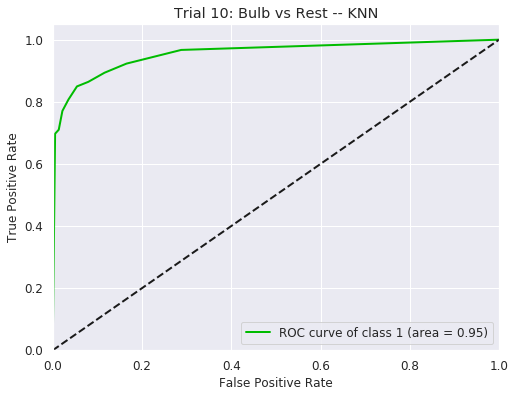

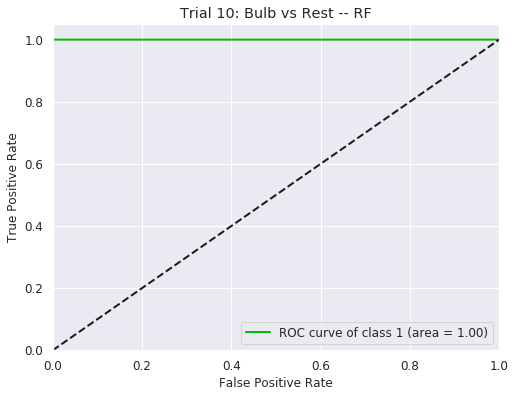

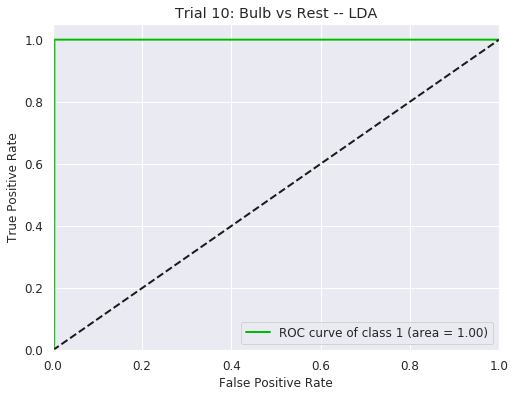

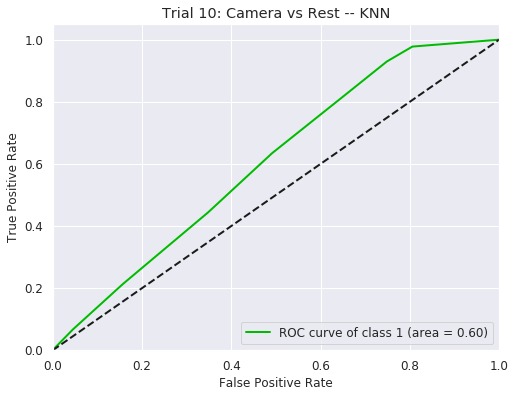

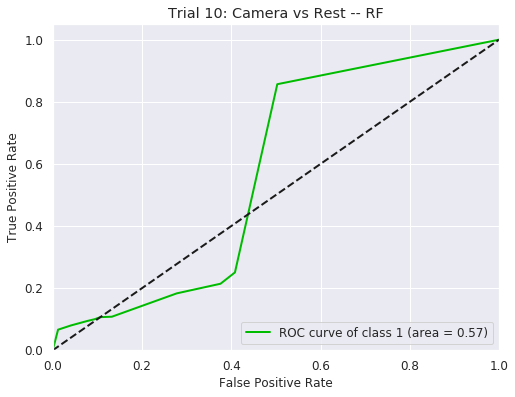

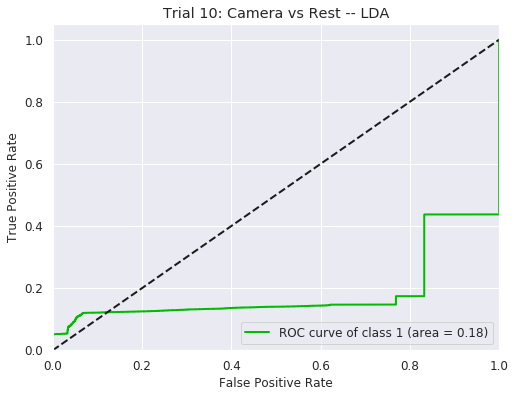

In [11]:
# Plotting ROC curves
sns.set(font_scale=1)
aucs = []

for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()

    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']
            
            # Calculate, store auc
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            aucs.append(auc)            
            
            # Plot ROC curve
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));

### Print csv results

In [12]:
df_alloutput = w.store_trial_results(trial_results)
df_alloutput['AUC'] = aucs
df_alloutput.to_csv('Results/wifi-alltrials.csv', mode='w')

In [13]:
df_performance_device = w.report_metrics_across('Device', df_alloutput)
display(df_performance_device)
df_performance_device.to_csv('Results/wifi-devtype-performance.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
plug,0.638211,0.185182,0.068775,0.546506,0.206489,0.076688,0.294866,0.240305,0.089247,0.615513,0.147950,0.054947
bulb,0.943094,0.055364,0.020562,0.947217,0.076109,0.028266,0.508155,0.318245,0.118193,0.984076,0.020569,0.007639
camera,0.496404,0.069754,0.025906,0.200469,0.163074,0.060564,0.883805,0.070029,0.026008,0.445832,0.230221,0.085502


In [14]:
df_performance_classifier = w.report_metrics_across('Classifier', df_alloutput)
display(df_performance_classifier)
df_performance_classifier.to_csv('Results/wifi-devtype-classifier.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
KNN,0.645682,0.179929,0.066824,0.556621,0.205855,0.076453,0.426309,0.360235,0.133788,0.685029,0.198677,0.073787
RF,0.732323,0.203211,0.075471,0.577618,0.374083,0.138931,0.637548,0.287814,0.106891,0.771713,0.191400,0.071084
LDA,0.699705,0.269042,0.099920,0.559953,0.425901,0.158176,0.622970,0.326308,0.121188,0.588679,0.372198,0.138231


In [15]:
device_types = ['bulb', 'camera', 'plug']
classifiers = ['KNN', 'LDA', 'RF']

### Time Performance

In [16]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in device_types:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 1.6607670784 seconds
(Bulb, KNN) : 0.248720884323 seconds
(Bulb, LDA) : 0.00916409492493 seconds
(Bulb, RF) : 0.0690438747406 seconds
(Camera, KNN) : 0.248905181885 seconds
(Camera, LDA) : 0.0354828834534 seconds
(Camera, RF) : 0.0868430137634 seconds
(Plug, KNN) : 0.269442081451 seconds
(Plug, LDA) : 0.00976395606995 seconds
(Plug, RF) : 0.0722050666809 seconds

Trial  1
Total time: 1.56132793427 seconds
(Bulb, KNN) : 0.241069078445 seconds
(Bulb, LDA) : 0.0093309879303 seconds
(Bulb, RF) : 0.0675549507141 seconds
(Camera, KNN) : 0.251925945282 seconds
(Camera, LDA) : 0.00952291488647 seconds
(Camera, RF) : 0.077043056488 seconds
(Plug, KNN) : 0.249105930328 seconds
(Plug, LDA) : 0.00927400588989 seconds
(Plug, RF) : 0.0719249248505 seconds

Trial  2
Total time: 1.57382798195 seconds
(Bulb, KNN) : 0.24231505394 seconds
(Bulb, LDA) : 0.00940299034119 seconds
(Bulb, RF) : 0.0742390155792 seconds
(Camera, KNN) : 0.252155065536 seconds
(Camera, LDA) : 0.00936508178711

### Feature Importance

In [17]:
# Extract feature importance values
df_featImp = pd.DataFrame()
for i,f in enumerate(w.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [18]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [19]:
feat_imp = df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False)
display(feat_imp)
feat_imp.to_csv('Results/wifi-feature_importance.csv', mode='w')

,Mean,StdDev,CI_MOE
PacketLength,0.200515,0.174103,0.110113
Dropcam,0.189165,0.213394,0.134962
Belkin,0.187989,0.196391,0.124208
Assoc_Packets,0.144089,0.087516,0.055350
QoS_Null,0.122334,0.091137,0.057640
Lifi,0.065112,0.081531,0.051565
QoS_Data,0.038420,0.043210,0.027329
Time,0.030186,0.016813,0.010634
Tp-link,0.012640,0.020953,0.013252
Data,0.009549,0.007457,0.004716


### Sampling Counts

In [20]:
print "Packet Counts Prior to Resampling"
print df["DeviceType"].value_counts()

Packet Counts Prior to Resampling
plug      85512
camera    71399
bulb       1231
Name: DeviceType, dtype: int64


Training Set plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

Test Set camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


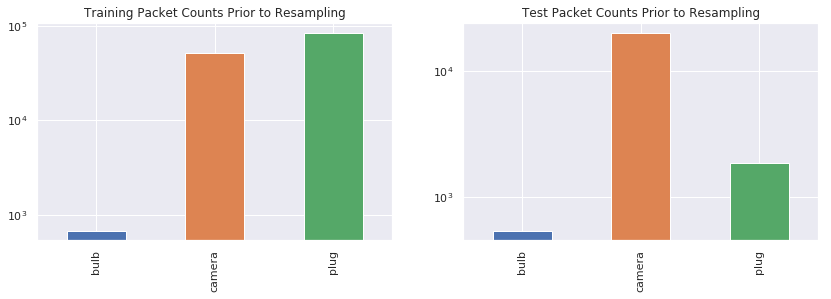

In [21]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling", logy=True);
print "Training Set", df_train["DeviceType"].value_counts()
print

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling", logy=True);
print "Test Set", df_test["DeviceType"].value_counts()

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


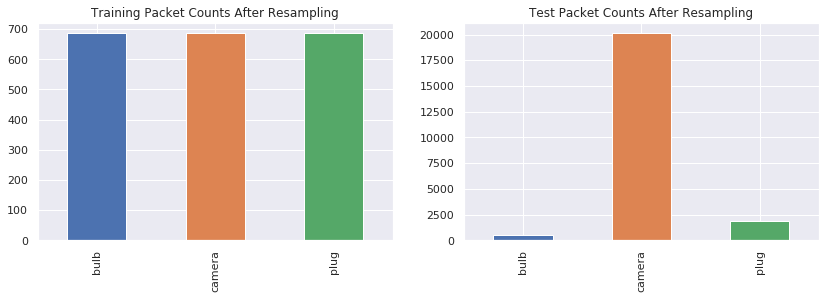

In [22]:
# Plot post-sampling
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
